# Noisy n-Local Network Optimization

In this notebook, we investigate different noise models applied to the $n$-local network.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time

from context import QNetOptimizer as QNopt

In [2]:
def bell_state_local_RY(settings, wires):
    qml.Hadamard(wires[0])
    qml.CNOT(wires=wires[0:2])
        
    qml.RY(settings[0], wires=wires[0])
    qml.RY(settings[1], wires=wires[1])

def static_nlocal_prepare_nodes(n):
    return [QNopt.PrepareNode(1, [2*i, 2*i + 1], bell_state_local_RY, 2) for i in range(n)]

def local_RY_measure_nodes(n):
    meas_nodes = [QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1)]
    meas_nodes.extend([
        QNopt.MeasureNode(2, 2, [2*i + 1, 2*i + 2], QNopt.local_RY, 2) for i in range(0,n-1)
    ])
    meas_nodes.append(QNopt.MeasureNode(2, 2, [2*n-1], QNopt.local_RY, 1))
    
    return meas_nodes

def qubit_noise_nodes(n, fn, chan_params):
    return [QNopt.NoiseNode([i], lambda settings, wires: fn(*chan_params[i], wires=wires[0])) for i in range(2*n)]

## Optimizing Bilocal Chains with Uniform Qubit Channel Noise

In this section, we optimize non-bilocality for the Bilocal Chain with different qubit noise channels.
The same noise is applied to each qubit independently. 

### Bilocal Depolarizing Channels

In [3]:
%%time

n = 2
prep_nodes = static_nlocal_prepare_nodes(n)
meas_nodes = local_RY_measure_nodes(n)

depolarized_bilocal_opt_dicts = []

for gamma in np.arange(0,0.121,0.03):
    print("gamma : ", gamma)
    depolarized_nodes = qubit_noise_nodes(n, qml.DepolarizingChannel, [[gamma]]*4)
    depolarized_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, depolarized_nodes)
    depolarized_bilocal_cost = QNopt.nlocal_chain_cost_22(depolarized_bilocal_ansatz)
    
    np.random.seed(1)
    depolarized_bilocal_settings = depolarized_bilocal_ansatz.rand_scenario_settings()

    depolarized_bilocal_opt_dict = QNopt.gradient_descent(
        depolarized_bilocal_cost,
        depolarized_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    depolarized_bilocal_opt_dicts.append(depolarized_bilocal_opt_dict)
    
    print("max score : ", depolarized_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.9088270063898309
iteration :  3 , score :  1.3812318715968455
iteration :  6 , score :  1.4102028617748599
iteration :  9 , score :  1.4137129298031832
iteration :  12 , score :  1.4141507737111247
max score :  1.4142056269440482
gamma :  0.03
iteration :  0 , score :  0.8375749690888679
iteration :  3 , score :  1.283585000482836
iteration :  6 , score :  1.3008121941131643
iteration :  9 , score :  1.3029431063147636
iteration :  12 , score :  1.3032750220556335
max score :  1.3033287497893276
gamma :  0.06
iteration :  0 , score :  0.7692311782083527
iteration :  3 , score :  1.1788927335753048
iteration :  6 , score :  1.1939182857746455
iteration :  9 , score :  1.1963996135263026
iteration :  12 , score :  1.1968759698685028
max score :  1.1969682081431037
gamma :  0.09
iteration :  0 , score :  0.7037956337482849
iteration :  3 , score :  1.0758287135344062
iteration :  6 , score :  1.0913285110764075
iteration :  9 , score :  1.094307340

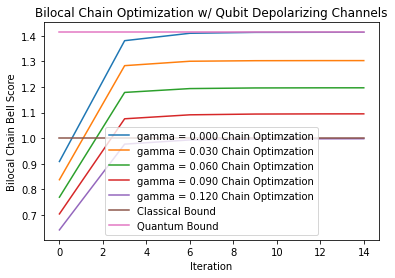

In [4]:
num_samples = len(depolarized_bilocal_opt_dicts[0]["samples"])

id = 0
gammas = np.arange(0,0.121,0.03)
for opt_dict in depolarized_bilocal_opt_dicts:
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.plot(depolarized_bilocal_opt_dicts[0]["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(depolarized_bilocal_opt_dicts[0]["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"Bilocal Chain Optimization w/ Qubit Depolarizing Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Bell Score")
plt.legend()
plt.show()

### Bilocal BitFlip Channels

In [5]:
n = 2
prep_nodes = static_nlocal_prepare_nodes(n)
meas_nodes = local_RY_measure_nodes(n)

bitflip_bilocal_opt_dicts = []

for gamma in np.arange(0,0.21,0.05):
    print("gamma : ", gamma)
    bitflip_nodes = qubit_noise_nodes(n, qml.BitFlip, [[gamma]]*4)
    bitflip_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, bitflip_nodes)
    bitflip_bilocal_cost = QNopt.nlocal_chain_cost_22(bitflip_bilocal_ansatz)
    
    np.random.seed(1)
    bitflip_bilocal_settings = bitflip_bilocal_ansatz.rand_scenario_settings()

    bitflip_bilocal_opt_dict = QNopt.gradient_descent(
        bitflip_bilocal_cost,
        bitflip_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    bitflip_bilocal_opt_dicts.append(bitflip_bilocal_opt_dict)
    
    print("max score : ", bitflip_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.9088270063898309
iteration :  3 , score :  1.3812318715968455
iteration :  6 , score :  1.4102028617748599
iteration :  9 , score :  1.4137129298031832
iteration :  12 , score :  1.4141507737111247
max score :  1.4142056269440482
gamma :  0.05
iteration :  0 , score :  0.8174004190005495
iteration :  3 , score :  1.2616556193084492
iteration :  6 , score :  1.2755037834466165
iteration :  9 , score :  1.2772986414393435
iteration :  12 , score :  1.2776412456929511
max score :  1.2777515099170382
gamma :  0.1
iteration :  0 , score :  0.7282559629789404
iteration :  3 , score :  1.1364240023588796
iteration :  6 , score :  1.14919815828958
iteration :  9 , score :  1.1518244286712802
iteration :  12 , score :  1.1529460077770834
max score :  1.1537376219959747
gamma :  0.15000000000000002
iteration :  0 , score :  0.641272316839045
iteration :  3 , score :  1.0172271181875885
iteration :  6 , score :  1.0341200709067524
iteration :  9 , score : 

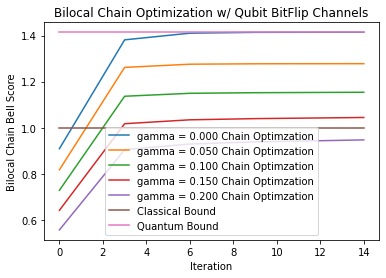

In [6]:
num_samples = len(bitflip_bilocal_opt_dicts[0]["samples"])

id = 0
gammas = np.arange(0,0.21,0.05)
for opt_dict in bitflip_bilocal_opt_dicts:
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.plot(bitflip_bilocal_opt_dicts[0]["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(bitflip_bilocal_opt_dicts[0]["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"Bilocal Chain Optimization w/ Qubit BitFlip Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Bell Score")
plt.legend()
plt.show()

### Bilocal Amplitude Damping

In [7]:
n = 2
prep_nodes = static_nlocal_prepare_nodes(n)
meas_nodes = local_RY_measure_nodes(n)

ampdamp_bilocal_opt_dicts = []

for gamma in np.arange(0,0.241,0.06):
    print("gamma : ", gamma)
    ampdamp_nodes = qubit_noise_nodes(n, qml.AmplitudeDamping, [[gamma]]*4)
    ampdamp_bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes, ampdamp_nodes)
    ampdamp_bilocal_cost = QNopt.nlocal_chain_cost_22(ampdamp_bilocal_ansatz)
    
    np.random.seed(1)
    ampdamp_bilocal_settings = ampdamp_bilocal_ansatz.rand_scenario_settings()

    ampdamp_bilocal_opt_dict = QNopt.gradient_descent(
        ampdamp_bilocal_cost,
        ampdamp_bilocal_settings,
        num_steps=15,
        step_size=0.8,
        sample_width = 3
    )
    
    ampdamp_bilocal_opt_dicts.append(ampdamp_bilocal_opt_dict)
    
    print("max score : ", ampdamp_bilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  0.9088270063898309
iteration :  3 , score :  1.3812318715968455
iteration :  6 , score :  1.4102028617748599
iteration :  9 , score :  1.4137129298031832
iteration :  12 , score :  1.4141507737111247
max score :  1.4142056269440482
gamma :  0.06
iteration :  0 , score :  0.8263958504418732
iteration :  3 , score :  1.2697633267899986
iteration :  6 , score :  1.285641781482362
iteration :  9 , score :  1.2876659715349699
iteration :  12 , score :  1.287993435395011
max score :  1.2880497428876152
gamma :  0.12
iteration :  0 , score :  0.7437299839337834
iteration :  3 , score :  1.147554623452833
iteration :  6 , score :  1.161512380759189
iteration :  9 , score :  1.1638769817213972
iteration :  12 , score :  1.1643759056262202
max score :  1.1645080199713478
gamma :  0.18
iteration :  0 , score :  0.6608234948609613
iteration :  3 , score :  1.0252999255066257
iteration :  6 , score :  1.0402779062487113
iteration :  9 , score :  1.043261316918

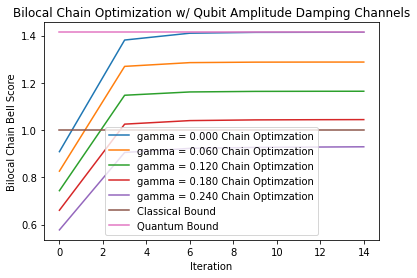

In [8]:
num_samples = len(ampdamp_bilocal_opt_dicts[0]["samples"])

id = 0
gammas = np.arange(0,0.241,0.06)
for opt_dict in ampdamp_bilocal_opt_dicts:
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1

plt.plot(ampdamp_bilocal_opt_dicts[0]["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(ampdamp_bilocal_opt_dicts[0]["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"Bilocal Chain Optimization w/ Qubit Amplitude Damping Channels")
plt.xlabel("Iteration")
plt.ylabel(r"Bilocal Chain Bell Score")
plt.legend()
plt.show()

## Optimizing the Trilocal Chain with Uniform Qubit Channel Noise


### Trilocal Depolarizing Channels

In [9]:
%%time

n = 3
prep_nodes3 = static_nlocal_prepare_nodes(n)
meas_nodes3 = local_RY_measure_nodes(n)

depolarized_trilocal_chain_ansatzes = []
depolarized_trilocal_opt_dicts = []

for gamma in np.arange(0,0.11,0.02):
    print("gamma : ", gamma)
    depolarized_noise_nodes = qubit_noise_nodes(n, qml.DepolarizingChannel, [[gamma]]*6)
    depolarized_trilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes3, meas_nodes3, depolarized_noise_nodes)
    
    depolarized_trilocal_chain_ansatzes.append(depolarized_trilocal_ansatz)
    
    depolarized_trilocal_cost = QNopt.nlocal_chain_cost_22(depolarized_trilocal_ansatz)
    
    np.random.seed(1)
    depolarized_trilocal_settings = depolarized_trilocal_ansatz.rand_scenario_settings()

    depolarized_trilocal_opt_dict = QNopt.gradient_descent(
        depolarized_trilocal_cost,
        depolarized_trilocal_settings,
        num_steps=25,
        step_size=0.8,
        sample_width=5
    )
    
    depolarized_trilocal_opt_dicts.append(depolarized_trilocal_opt_dict)
    print("max score : ", depolarized_trilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  1.00193272570898
iteration :  5 , score :  1.3858363951522445
iteration :  10 , score :  1.4131658820154729
iteration :  15 , score :  1.4141763871069053
iteration :  20 , score :  1.4142122418674525
max score :  1.4142135153194544
gamma :  0.02
iteration :  0 , score :  0.9238965645206055
iteration :  5 , score :  1.2724155093420215
iteration :  10 , score :  1.302456842886417
iteration :  15 , score :  1.3039880240389206
iteration :  20 , score :  1.304062819016874
max score :  1.3040664621280749
gamma :  0.04
iteration :  0 , score :  0.8500213186162411
iteration :  5 , score :  1.1630907242069501
iteration :  10 , score :  1.1972787281780275
iteration :  15 , score :  1.1996301721644722
iteration :  20 , score :  1.199782341131558
max score :  1.1997921334860222
gamma :  0.06
iteration :  0 , score :  0.7801929903168738
iteration :  5 , score :  1.0592182811662323
iteration :  10 , score :  1.0974782552921536
iteration :  15 , score :  1.10091

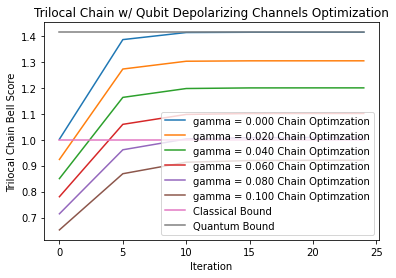

In [10]:
num_samples = len(depolarized_trilocal_opt_dicts[0]["samples"])

id = 0
gammas = np.arange(0,0.11,0.02)
for opt_dict in depolarized_trilocal_opt_dicts:
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1
    

plt.plot(depolarized_trilocal_opt_dicts[0]["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(depolarized_trilocal_opt_dicts[0]["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"Trilocal Chain w/ Qubit Depolarizing Channels Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"Trilocal Chain Bell Score")
plt.legend()
plt.show()

### Trilocal BitFlip Channels

In [11]:
%%time

n = 3
prep_nodes3 = static_nlocal_prepare_nodes(n)
meas_nodes3 = local_RY_measure_nodes(n)

bitflip_trilocal_chain_ansatzes = []
bitflip_trilocal_opt_dicts = []

for gamma in np.arange(0,0.24,0.06):
    print("gamma : ", gamma)
    bitflip_noise_nodes = qubit_noise_nodes(n, qml.BitFlip, [[gamma]]*6)
    bitflip_trilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes3, meas_nodes3, bitflip_noise_nodes)
    
    bitflip_trilocal_chain_ansatzes.append(bitflip_trilocal_ansatz)
    
    bitflip_trilocal_cost = QNopt.nlocal_chain_cost_22(bitflip_trilocal_ansatz)
    
    np.random.seed(1)
    bitflip_trilocal_settings = bitflip_trilocal_ansatz.rand_scenario_settings()

    bitflip_trilocal_opt_dict = QNopt.gradient_descent(
        bitflip_trilocal_cost,
        bitflip_trilocal_settings,
        num_steps=36,
        step_size=0.8,
        sample_width=4
    )
    
    bitflip_trilocal_opt_dicts.append(bitflip_trilocal_opt_dict)
    print("max score : ", bitflip_trilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  1.00193272570898
iteration :  4 , score :  1.361276526688841
iteration :  8 , score :  1.4102470654646506
iteration :  12 , score :  1.4139379070967297
iteration :  16 , score :  1.4141944999235596
iteration :  20 , score :  1.4142122418674525
iteration :  24 , score :  1.4142134707236322
iteration :  28 , score :  1.414213556002026
iteration :  32 , score :  1.4142135619296323
max score :  1.4142135623421952
gamma :  0.06
iteration :  0 , score :  0.8277449586968538
iteration :  4 , score :  1.1078325339623352
iteration :  8 , score :  1.1668201000150975
iteration :  12 , score :  1.1757344033610302
iteration :  16 , score :  1.1782200012610364
iteration :  20 , score :  1.1805001009171479
iteration :  24 , score :  1.1834961677951146
iteration :  28 , score :  1.1874937117335524
iteration :  32 , score :  1.1926466080065699
max score :  1.1989584036346315
gamma :  0.12
iteration :  0 , score :  0.6692933631754716
iteration :  4 , score :  0.8858

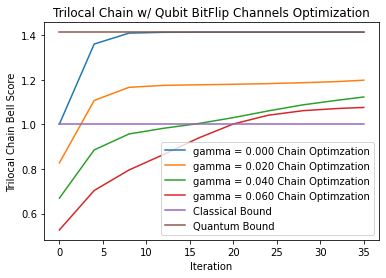

In [12]:
num_samples = len(bitflip_trilocal_opt_dicts[0]["samples"])

id = 0
gammas = np.arange(0,0.11,0.02)
for opt_dict in bitflip_trilocal_opt_dicts:
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1
    

plt.plot(bitflip_trilocal_opt_dicts[0]["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(bitflip_trilocal_opt_dicts[0]["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"Trilocal Chain w/ Qubit BitFlip Channels Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"Trilocal Chain Bell Score")
plt.legend()
plt.show()

### Trilocal Amplitude Damping Channels

In [13]:
%%time

n = 3
prep_nodes3 = static_nlocal_prepare_nodes(n)
meas_nodes3 = local_RY_measure_nodes(n)

ampdamp_trilocal_chain_ansatzes = []
ampdamp_trilocal_opt_dicts = []

for gamma in np.arange(0,0.21,0.04):
    print("gamma : ", gamma)
    ampdamp_noise_nodes = qubit_noise_nodes(n, qml.AmplitudeDamping, [[gamma]]*6)
    ampdamp_trilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes3, meas_nodes3, ampdamp_noise_nodes)
    
    ampdamp_trilocal_chain_ansatzes.append(ampdamp_trilocal_ansatz)
    
    ampdamp_trilocal_cost = QNopt.nlocal_chain_cost_22(ampdamp_trilocal_ansatz)
    
    np.random.seed(1)
    ampdamp_trilocal_settings = ampdamp_trilocal_ansatz.rand_scenario_settings()

    ampdamp_trilocal_opt_dict = QNopt.gradient_descent(
        ampdamp_trilocal_cost,
        ampdamp_trilocal_settings,
        num_steps=20,
        step_size=0.8,
        sample_width=4
    )
    
    ampdamp_trilocal_opt_dicts.append(ampdamp_trilocal_opt_dict)
    print("max score : ", ampdamp_trilocal_opt_dict["opt_score"])

gamma :  0.0
iteration :  0 , score :  1.00193272570898
iteration :  4 , score :  1.361276526688841
iteration :  8 , score :  1.4102470654646506
iteration :  12 , score :  1.4139379070967297
iteration :  16 , score :  1.4141944999235596
max score :  1.4142122418674525
gamma :  0.04
iteration :  0 , score :  0.9146153341277959
iteration :  4 , score :  1.2336777077848762
iteration :  8 , score :  1.2851785597951055
iteration :  12 , score :  1.2903504027036967
iteration :  16 , score :  1.2908420238499587
max score :  1.2909003610859764
gamma :  0.08
iteration :  0 , score :  0.8334546995513692
iteration :  4 , score :  1.1113792336038661
iteration :  8 , score :  1.166739063872244
iteration :  12 , score :  1.1741024653520054
iteration :  16 , score :  1.1750519441428404
max score :  1.1752420921230193
gamma :  0.12
iteration :  0 , score :  0.758241388551518
iteration :  4 , score :  0.9970030810360111
iteration :  8 , score :  1.0550924598656906
iteration :  12 , score :  1.065049932

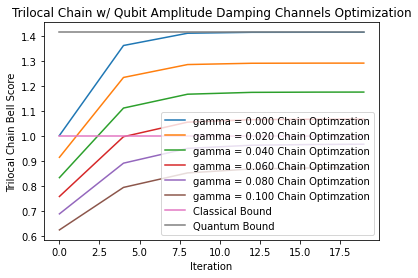

In [14]:
num_samples = len(ampdamp_trilocal_opt_dicts[0]["samples"])

id = 0
gammas = np.arange(0,0.11,0.02)
for opt_dict in ampdamp_trilocal_opt_dicts:
    plt.plot(opt_dict["samples"], opt_dict["scores"], label = r"gamma = {:.3f} Chain Optimzation".format(gammas[id]))
    id += 1
    

plt.plot(ampdamp_trilocal_opt_dicts[0]["samples"], [1]*num_samples, label = "Classical Bound")
plt.plot(ampdamp_trilocal_opt_dicts[0]["samples"], [2/np.sqrt(2)]*num_samples, label = "Quantum Bound")
plt.title(r"Trilocal Chain w/ Qubit Amplitude Damping Channels Optimization")
plt.xlabel("Iteration")
plt.ylabel(r"Trilocal Chain Bell Score")
plt.legend()
plt.show()